In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Input, Multiply, TimeDistributed, Softmax, Lambda, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
        

def print_results(outcome_variable):
        ### Deep Learning analysis data preparation
        # Load data from a CSV file
        df = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-01-10/df_dl_continous.csv')
        df_mask = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-01-10/df_dl_continous_mask.csv')
        df_delta = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-01-10/df_dl_continous_delta.csv')
        
        # Drop rows with NaN in the target column before any operations
        df = df.dropna(subset=[outcome_variable])
        df = df.reset_index(drop=True)
        
        df_mask = df_mask.dropna(subset=[outcome_variable])
        df_mask = df_mask.reset_index(drop=True)
        
        df_delta = df_delta.dropna(subset=[outcome_variable])
        df_delta = df_delta.reset_index(drop=True)
        
        # Selecting features and the target
        features_categorical = ["TYPE_VISIT","SITE",
                    "INF_PRES_CEPH","INF_PRES_BREECH","INF_PRES_TRANS","INF_PRES_BROW","INF_PRES_OTHER",
                    "ASPHYXIA_IND","STILLBIRTH_IND","PRETERM_IND","POSTTERM_IND","GEST_HTN_IND","PREECLAMPSIA_IND","GEST_DIAB_IND","PREMATURE_RUPTURE_IND","OBSTR_LABOR_IND",
                    "MISCARRIAGE","PAID_WORK","PARITY_2","PARITY_1","WEALTH_QUINT_1","WEALTH_QUINT_2","WEALTH_QUINT_3","WEALTH_QUINT_4","SCHOOL_MORE10","WATER_IMPROVED","TOILET_IMPROVED","STOVE_FUEL","HH_SMOKE","SMOKE","CHEW_TOBACCO","CHEW_BETELNUT","AGE_GROUP","BMI_LEVEL_ENROLL",
                    "MEM_CES","MEM_ART","MEM_SPON","LABOR_ANY","PRO_LABOR","OBS_LABOR","MAT_PRETERM_ANY",
                    "HEM_APH","HIV_POSITIVE_ENROLL","SYPH_POSITIVE_ENROLL","GON_POSITIVE_ENROLL","CHL_POSITIVE_ENROLL","GENU_POSITIVE_ENROLL","OTHR_POSITIVE_ENROLL","MAL_POSITIVE_ENROLL","HBV_POSITIVE_ENROLL","HCV_POSITIVE_ENROLL","TB_SYMP_POSITIVE_ENROLL",
                    "M04_IRON_ORAL_CMOCCUR","M04_IFA_CMOCCUR","M04_CALCIUM_CMOCCUR","M04_VITAMIN_A_CMOCCUR","M04_MICRONUTRIENT_CMOCCUR","M04_ANTHELMINTHIC_CMOCCUR"]
        
        features_continous = ["MAT_AGE","BMI_ENROLL","MUAC_ENROLL","M08_CBC_MCV_LBORRES", "M08_VITB12_COB_LBORRES", "M08_VITB12_HOL_LBORRES", "M08_IRON_TOT_UGDL_LBORRES",
                        "M08_VITA_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_ZINC_LBORRES", "M08_IRON_HEP_LBORRES","M08_IODINE_LBORRES","M08_RBP4_LBORRES","M08_CRP_LBORRES","M08_AGP_LBORRES", "M08_CBC_HB_LBORRES"]
        
        # Separate categorical and continuous features
        df_categorical = df[features_categorical]
        df_continuous = df[features_continous]
        
        # Rescale continuous features to (0, 1) range
        scaler = MinMaxScaler()
        df_continuous_scaled = pd.DataFrame(scaler.fit_transform(df_continuous), columns=features_continous)
        
        # Concatenate scaled continuous features with categorical features
        X = pd.concat([df_categorical, df_continuous_scaled], axis=1)
        
        features_static = ["INF_PRES_CEPH","INF_PRES_BREECH","INF_PRES_TRANS","INF_PRES_BROW","INF_PRES_OTHER","SITE",
                        "ASPHYXIA_IND","STILLBIRTH_IND","PRETERM_IND","POSTTERM_IND","GEST_HTN_IND","PREECLAMPSIA_IND","GEST_DIAB_IND","PREMATURE_RUPTURE_IND","OBSTR_LABOR_IND",
                        "MISCARRIAGE","PAID_WORK","PARITY_2","PARITY_1","WEALTH_QUINT_1","WEALTH_QUINT_2","WEALTH_QUINT_3","WEALTH_QUINT_4","SCHOOL_MORE10","WATER_IMPROVED","TOILET_IMPROVED","STOVE_FUEL","HH_SMOKE","SMOKE","CHEW_TOBACCO","CHEW_BETELNUT","AGE_GROUP","BMI_LEVEL_ENROLL",
                        "MAT_AGE","BMI_ENROLL","MUAC_ENROLL",
                        "MEM_CES","MEM_ART","MEM_SPON","LABOR_ANY","PRO_LABOR","OBS_LABOR","MAT_PRETERM_ANY",
                        "HEM_APH","HIV_POSITIVE_ENROLL","SYPH_POSITIVE_ENROLL","GON_POSITIVE_ENROLL","CHL_POSITIVE_ENROLL","GENU_POSITIVE_ENROLL","OTHR_POSITIVE_ENROLL","MAL_POSITIVE_ENROLL","HBV_POSITIVE_ENROLL","HCV_POSITIVE_ENROLL","TB_SYMP_POSITIVE_ENROLL"]
        
        features_temporal = ["TYPE_VISIT","M04_IRON_ORAL_CMOCCUR","M04_IFA_CMOCCUR","M04_CALCIUM_CMOCCUR","M04_VITAMIN_A_CMOCCUR","M04_MICRONUTRIENT_CMOCCUR","M04_ANTHELMINTHIC_CMOCCUR",
                             "M08_CBC_MCV_LBORRES", "M08_VITB12_COB_LBORRES", "M08_VITB12_HOL_LBORRES", "M08_IRON_TOT_UGDL_LBORRES",
                        "M08_VITA_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_ZINC_LBORRES", "M08_IRON_HEP_LBORRES","M08_IODINE_LBORRES","M08_RBP4_LBORRES","M08_CRP_LBORRES","M08_AGP_LBORRES", "M08_CBC_HB_LBORRES"]
        
        ##Static and temporal data
        X_static = X[features_static]
        
        X_temporal = X[features_temporal]
        X_temporal_delta = df_delta[features_temporal]
        X_temporal_mask = df_mask[features_temporal]
        
        y = df[outcome_variable]
        threshold = (df[outcome_variable] == 1).mean()
        
        # One-hot encoding for non-binary categorical features in X
        X = pd.get_dummies(X, columns=['TYPE_VISIT','SITE'], dummy_na=False)
        X_static = pd.get_dummies(X_static, columns=['SITE'], dummy_na=False)
        X_temporal = pd.get_dummies(X_temporal, columns=['TYPE_VISIT'], dummy_na=False)
        X_temporal_delta = pd.get_dummies(X_temporal_delta, columns=['TYPE_VISIT'], dummy_na=False)
        X_temporal_mask = pd.get_dummies(X_temporal_mask, columns=['TYPE_VISIT'], dummy_na=False)
        
        # Preprocess for Keras models (3D matrix)
        n_samples = X_temporal.shape[0] // 5 
        X_static_keras = X_static.iloc[::5].values.astype('float32')
        
        X_temporal_keras = X_temporal.values.reshape(n_samples, 5, X_temporal.shape[1]).astype('float32')
        X_temporal_delta_keras = X_temporal_delta.values.reshape(n_samples, 5, X_temporal_delta.shape[1]).astype('float32')
        X_temporal_mask_keras = X_temporal_mask.values.reshape(n_samples, 5, X_temporal_mask.shape[1]).astype('float32')
        
        X_keras = X.values.reshape(n_samples, 5, X.shape[1]).astype('float32')
        
        # Align y for Keras models
        y_keras = y.iloc[::5].values.astype('float32')
        
        ### Machine Learning analysis data preparation
        # Load data from a CSV file
        ml = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-01-10/df_dl_continous_wide.csv')
        
        # Drop rows with NaN in the target column before any operations
        ml = ml.dropna(subset=[outcome_variable])
        ml = ml.reset_index(drop=True)
        threshold = (ml[outcome_variable] == 1).mean()
        
        # Normalize specified features before imputing missing values
        features_to_normalize = ['MAT_AGE', 'BMI_ENROLL', 'MUAC_ENROLL',
                                "M08_CBC_MCV_LBORRES_1", "M08_CBC_MCV_LBORRES_2", "M08_CBC_MCV_LBORRES_3", "M08_CBC_MCV_LBORRES_4", "M08_CBC_MCV_LBORRES_5",
                                "M08_VITB12_COB_LBORRES_1", "M08_VITB12_COB_LBORRES_2", "M08_VITB12_COB_LBORRES_3", "M08_VITB12_COB_LBORRES_4", "M08_VITB12_COB_LBORRES_5",
                                "M08_VITB12_HOL_LBORRES_1", "M08_VITB12_HOL_LBORRES_2", "M08_VITB12_HOL_LBORRES_3", "M08_VITB12_HOL_LBORRES_4", "M08_VITB12_HOL_LBORRES_5",
                                "M08_IRON_TOT_UGDL_LBORRES_1", "M08_IRON_TOT_UGDL_LBORRES_2", "M08_IRON_TOT_UGDL_LBORRES_3", "M08_IRON_TOT_UGDL_LBORRES_4", "M08_IRON_TOT_UGDL_LBORRES_5",
                                "M08_VITA_UGDL_LBORRES_1", "M08_VITA_UGDL_LBORRES_2", "M08_VITA_UGDL_LBORRES_3", "M08_VITA_UGDL_LBORRES_4", "M08_VITA_UGDL_LBORRES_5",
                                "M08_FERRITIN_LBORRES_1", "M08_FERRITIN_LBORRES_2", "M08_FERRITIN_LBORRES_3", "M08_FERRITIN_LBORRES_4", "M08_FERRITIN_LBORRES_5",
                                "M08_ZINC_LBORRES_1", "M08_ZINC_LBORRES_2", "M08_ZINC_LBORRES_3", "M08_ZINC_LBORRES_4", "M08_ZINC_LBORRES_5",
                                "M08_IRON_HEP_LBORRES_1", "M08_IRON_HEP_LBORRES_2", "M08_IRON_HEP_LBORRES_3", "M08_IRON_HEP_LBORRES_4", "M08_IRON_HEP_LBORRES_5",
                                "M08_IODINE_LBORRES_1", "M08_IODINE_LBORRES_2", "M08_IODINE_LBORRES_3", "M08_IODINE_LBORRES_4", "M08_IODINE_LBORRES_5",
                                "M08_RBP4_LBORRES_1", "M08_RBP4_LBORRES_2", "M08_RBP4_LBORRES_3", "M08_RBP4_LBORRES_4", "M08_RBP4_LBORRES_5",
                                "M08_CRP_LBORRES_1", "M08_CRP_LBORRES_2", "M08_CRP_LBORRES_3", "M08_CRP_LBORRES_4", "M08_CRP_LBORRES_5",
                                "M08_AGP_LBORRES_1", "M08_AGP_LBORRES_2", "M08_AGP_LBORRES_3", "M08_AGP_LBORRES_4", "M08_AGP_LBORRES_5",
                                "M08_CBC_HB_LBORRES_1", "M08_CBC_HB_LBORRES_2", "M08_CBC_HB_LBORRES_3", "M08_CBC_HB_LBORRES_4", "M08_CBC_HB_LBORRES_5"]
        
        # Create a MinMaxScaler instance
        scaler = MinMaxScaler()
        
        ml[features_to_normalize] = scaler.fit_transform(ml[features_to_normalize])
        
        # Selecting features and the target for ml dataset
        features_ml = ["INF_PRES_CEPH","INF_PRES_BREECH","INF_PRES_TRANS","INF_PRES_BROW","INF_PRES_OTHER",
                        "ASPHYXIA_IND","STILLBIRTH_IND","PRETERM_IND","POSTTERM_IND","GEST_HTN_IND","PREECLAMPSIA_IND","GEST_DIAB_IND","PREMATURE_RUPTURE_IND","OBSTR_LABOR_IND",
                        "MISCARRIAGE","PAID_WORK","PARITY_2","PARITY_1","WEALTH_QUINT_1","WEALTH_QUINT_2","WEALTH_QUINT_3","WEALTH_QUINT_4","SCHOOL_MORE10","WATER_IMPROVED","TOILET_IMPROVED","STOVE_FUEL","HH_SMOKE","SMOKE","CHEW_TOBACCO","CHEW_BETELNUT","AGE_GROUP","BMI_LEVEL_ENROLL",
                        "MAT_AGE","BMI_ENROLL","MUAC_ENROLL",
                        "MEM_CES","MEM_ART","MEM_SPON","LABOR_ANY","PRO_LABOR","OBS_LABOR","MAT_PRETERM_ANY",
                        "HEM_APH","HIV_POSITIVE_ENROLL","SYPH_POSITIVE_ENROLL","GON_POSITIVE_ENROLL","CHL_POSITIVE_ENROLL","GENU_POSITIVE_ENROLL","OTHR_POSITIVE_ENROLL","MAL_POSITIVE_ENROLL","HBV_POSITIVE_ENROLL","HCV_POSITIVE_ENROLL","TB_SYMP_POSITIVE_ENROLL",
                        "SITE",
                        "M04_IRON_ORAL_CMOCCUR_1", "M04_IRON_ORAL_CMOCCUR_2", "M04_IRON_ORAL_CMOCCUR_3", "M04_IRON_ORAL_CMOCCUR_4", "M04_IRON_ORAL_CMOCCUR_5",
                        "M04_IFA_CMOCCUR_1", "M04_IFA_CMOCCUR_2", "M04_IFA_CMOCCUR_3", "M04_IFA_CMOCCUR_4", "M04_IFA_CMOCCUR_5",
                        "M04_CALCIUM_CMOCCUR_1", "M04_CALCIUM_CMOCCUR_2", "M04_CALCIUM_CMOCCUR_3", "M04_CALCIUM_CMOCCUR_4", "M04_CALCIUM_CMOCCUR_5",
                        "M04_VITAMIN_A_CMOCCUR_1", "M04_VITAMIN_A_CMOCCUR_2", "M04_VITAMIN_A_CMOCCUR_3", "M04_VITAMIN_A_CMOCCUR_4", "M04_VITAMIN_A_CMOCCUR_5",
                        "M04_MICRONUTRIENT_CMOCCUR_1", "M04_MICRONUTRIENT_CMOCCUR_2", "M04_MICRONUTRIENT_CMOCCUR_3", "M04_MICRONUTRIENT_CMOCCUR_4", "M04_MICRONUTRIENT_CMOCCUR_5",
                        "M04_ANTHELMINTHIC_CMOCCUR_1", "M04_ANTHELMINTHIC_CMOCCUR_2", "M04_ANTHELMINTHIC_CMOCCUR_3", "M04_ANTHELMINTHIC_CMOCCUR_4", "M04_ANTHELMINTHIC_CMOCCUR_5",
                        "M08_CBC_MCV_LBORRES_1", "M08_CBC_MCV_LBORRES_2", "M08_CBC_MCV_LBORRES_3", "M08_CBC_MCV_LBORRES_4", "M08_CBC_MCV_LBORRES_5",
                        "M08_VITB12_COB_LBORRES_1", "M08_VITB12_COB_LBORRES_2", "M08_VITB12_COB_LBORRES_3", "M08_VITB12_COB_LBORRES_4", "M08_VITB12_COB_LBORRES_5",
                        "M08_VITB12_HOL_LBORRES_1", "M08_VITB12_HOL_LBORRES_2", "M08_VITB12_HOL_LBORRES_3", "M08_VITB12_HOL_LBORRES_4", "M08_VITB12_HOL_LBORRES_5",
                        "M08_IRON_TOT_UGDL_LBORRES_1", "M08_IRON_TOT_UGDL_LBORRES_2", "M08_IRON_TOT_UGDL_LBORRES_3", "M08_IRON_TOT_UGDL_LBORRES_4", "M08_IRON_TOT_UGDL_LBORRES_5",
                        "M08_VITA_UGDL_LBORRES_1", "M08_VITA_UGDL_LBORRES_2", "M08_VITA_UGDL_LBORRES_3", "M08_VITA_UGDL_LBORRES_4", "M08_VITA_UGDL_LBORRES_5",
                        "M08_FERRITIN_LBORRES_1", "M08_FERRITIN_LBORRES_2", "M08_FERRITIN_LBORRES_3", "M08_FERRITIN_LBORRES_4", "M08_FERRITIN_LBORRES_5",
                        "M08_ZINC_LBORRES_1", "M08_ZINC_LBORRES_2", "M08_ZINC_LBORRES_3", "M08_ZINC_LBORRES_4", "M08_ZINC_LBORRES_5",
                        "M08_IRON_HEP_LBORRES_1", "M08_IRON_HEP_LBORRES_2", "M08_IRON_HEP_LBORRES_3", "M08_IRON_HEP_LBORRES_4", "M08_IRON_HEP_LBORRES_5",
                        "M08_IODINE_LBORRES_1", "M08_IODINE_LBORRES_2", "M08_IODINE_LBORRES_3", "M08_IODINE_LBORRES_4", "M08_IODINE_LBORRES_5",
                        "M08_RBP4_LBORRES_1", "M08_RBP4_LBORRES_2", "M08_RBP4_LBORRES_3", "M08_RBP4_LBORRES_4", "M08_RBP4_LBORRES_5",
                        "M08_CRP_LBORRES_1", "M08_CRP_LBORRES_2", "M08_CRP_LBORRES_3", "M08_CRP_LBORRES_4", "M08_CRP_LBORRES_5",
                        "M08_AGP_LBORRES_1", "M08_AGP_LBORRES_2", "M08_AGP_LBORRES_3", "M08_AGP_LBORRES_4", "M08_AGP_LBORRES_5",
                        "M08_CBC_HB_LBORRES_1", "M08_CBC_HB_LBORRES_2", "M08_CBC_HB_LBORRES_3", "M08_CBC_HB_LBORRES_4", "M08_CBC_HB_LBORRES_5"]
        
        X_ml = ml[features_ml]
        y_ml = ml[outcome_variable]
        
        X_ml = X_ml.fillna(0)
        X_ml = pd.get_dummies(X_ml, columns=['SITE'], dummy_na=False)
        
        # Preprocess for scikit-learn models (2D matrix)
        X_sklearn = X_ml.values.astype('float32')
        y_sklearn = y_ml.values.astype('float32')
        
        def evaluate_model(model_func, X, y, model_type="sklearn", threshold=threshold):
            # 10-fold cross-validation
            kf = KFold(n_splits=10, shuffle=True, random_state=42)
            
            # Lists to store scores for each fold
            precision_scores = []
            recall_scores = []
            f1_scores = []  # List to store F1 scores
            roc_auc_scores = []  # List to store ROC-AUC scores
            
            # Cross-validation loop
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                if model_type == "sklearn":
                    # Split training data into 90% training and 10% validation
                    train_size = int(0.9 * len(X_train))
                    X_train_part, X_val = X_train[:train_size], X_train[train_size:]
                    y_train_part, y_val = y_train[:train_size], y_train[train_size:]
                    
                    # scikit-learn model: Logistic Regression, Random Forest, SVM
                    model = model_func()
                    model.fit(X_train_part, y_train_part)  # Train on 90% of the training data
        
                    y_val_pred_prob = model.predict_proba(X_val)[:, 1]  # Predicted probabilities for positive class
                    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for positive class:
                
                else:  # Keras models: GRU, RETAIN, PredictPTB
                    X_train_part, X_val = X_train[:int(0.9 * len(X_train))], X_train[int(0.9 * len(X_train)):]
                    y_train_part, y_val = y_train[:int(0.9 * len(y_train))], y_train[int(0.9 * len(y_train)):]
                    
                    model = model_func(input_shape=(X_train_part.shape[1], X_train_part.shape[2]))
                    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
                    
                    # Train the Keras model with early stopping
                    model.fit(X_train_part, y_train_part, epochs=200, batch_size=16, verbose=0, 
                              validation_data=(X_val, y_val), callbacks=[early_stopping])
                    
                    y_pred_prob = model.predict(X_test)  # Predicted probabilities
                
                y_pred = (y_pred_prob > threshold).astype('int32')
                
                # Calculate metrics for this fold
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)  # Calculate F1 score
                roc_auc = roc_auc_score(y_test, y_pred_prob)  # Calculate ROC-AUC score
                
                # Append scores
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(f1)  # Append F1 score
                roc_auc_scores.append(roc_auc)  # Append ROC-AUC score
            
            # Compute and return mean scores across all folds
            mean_precision = np.mean(precision_scores)
            mean_recall = np.mean(recall_scores)
            mean_f1 = np.mean(f1_scores)  # Mean F1 score
            mean_roc_auc = np.mean(roc_auc_scores)  # Mean ROC-AUC score
            
            return mean_precision, mean_recall, mean_f1, mean_roc_auc
        
        # 1. Logistic Regression
        def logistic_regression():
            return LogisticRegression(max_iter=1000)
        
        # 2. Random Forest
        def random_forest():
            return RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        
        # 3. SVM model
        def svm_model():
            return SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
            
        # 4. PredictPTB model
        def build_predict_ptb(input_shape):
            inputs = Input(shape=input_shape)
            visit_embedding = TimeDistributed(Dense(64, activation='relu'))(inputs)
            rnn_beta, _ = GRU(32, return_sequences=True, return_state=True)(visit_embedding)
            beta = TimeDistributed(Dense(64, activation='tanh'))(rnn_beta)
            elementwise_prod = Multiply()([beta, visit_embedding])
            context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(elementwise_prod)
            output = Dense(1, activation='sigmoid')(context_vector)
            model = Model(inputs=inputs, outputs=output)
            model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')
            return model
        
        # 5. RETAIN model
        def build_retain(input_shape):
            inputs = Input(shape=input_shape)
            visit_embedding = TimeDistributed(Dense(64, activation='relu'))(inputs)
            rnn_alpha, _ = GRU(32, return_sequences=True, return_state=True)(visit_embedding)
            attention_scores = TimeDistributed(Dense(1))(rnn_alpha)
            alpha = Softmax(axis=1)(attention_scores)
            rnn_beta, _ = GRU(32, return_sequences=True, return_state=True)(visit_embedding)
            beta = TimeDistributed(Dense(64, activation='tanh'))(rnn_beta)
            weighted_context = Multiply()([alpha, Multiply()([beta, visit_embedding])])
            context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted_context)
            output = Dense(1, activation='sigmoid')(context_vector)
            model = Model(inputs=inputs, outputs=output)
            model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')
            return model
        
        # 6. GRU model
        def build_gru(input_shape):
            model = Sequential([
                Input(shape=input_shape),
                GRU(32, activation='relu'),
                Dropout(0.5),
                Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')
            return model
        
        #### 7. GRUD With Static Attention
        class GRUDWithStaticAttention(nn.Module):
            def __init__(self, input_size, hidden_size, output_size, mean_values, static_input_size, static_embedding_size):
                """
                GRU-D model with attention mechanism generated from static data.
                
                Args:
                    input_size (int): Number of input features for temporal data.
                    hidden_size (int): Number of hidden units in GRU.
                    output_size (int): Number of output classes (for classification tasks).
                    mean_values (torch.Tensor): Empirical mean values for each input feature.
                    static_input_size (int): Number of input features for static data.
                    static_embedding_size (int): Size of the embedding for static data.
                """
                super(GRUDWithStaticAttention, self).__init__()
                
                # Temporal (GRU-D) parameters
                self.input_size = input_size
                self.hidden_size = hidden_size
                self.output_size = output_size
                
                self.mean_values = mean_values
                
                self.gamma_x = nn.Linear(input_size, input_size)
                
                # GRU gate parameters (temporal part) with combined input, hidden state, and mask
                self.zl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Update gate
                self.rl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Reset gate
                self.hl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Candidate hidden state
        
                # Embedding or processing static data
                self.static_fc = nn.Linear(static_input_size, static_embedding_size)
        
                # Attention mechanism based on static data
                self.attention = nn.Linear(static_embedding_size, hidden_size)
        
                # Fully connected output layer
                self.fc = nn.Linear(hidden_size, output_size)
        
            def forward(self, x, m, delta, static_data):
                """
                Forward pass of GRU-D with static data attention.
                
                Args:
                    x (torch.Tensor): Temporal input data [batch_size, seq_len, input_size].
                    m (torch.Tensor): Masking vector [batch_size, seq_len, input_size].
                    delta (torch.Tensor): Time intervals [batch_size, seq_len, input_size].
                    static_data (torch.Tensor): Static data input [batch_size, static_input_size].
                """
                batch_size, seq_len, _ = x.size()
                
                # Process static data to generate attention weights
                static_embed = torch.relu(self.static_fc(static_data))  # [batch_size, static_embedding_size]
                
                # Generate attention weights from static data
                attention_weights = torch.sigmoid(self.attention(static_embed))  # [batch_size, hidden_size]
                
                # Initialize hidden state
                h = torch.zeros(batch_size, self.hidden_size).to(x.device)
                
                for t in range(seq_len):
                    # Corrected input decay mechanism
                    gamma_x_t = torch.exp(-F.relu(self.gamma_x(delta[:, t, :])))
                    x_t_hat = m[:, t, :] * x[:, t, :] + (1 - m[:, t, :]) * (gamma_x_t * self.mean_values + (1 - gamma_x_t) * x[:, t, :])
                    
                    # Concatenate input, hidden state, and mask
                    combined = torch.cat([x_t_hat, h, m[:, t, :]], dim=-1)
        
                    # GRU gates
                    r_t = torch.sigmoid(self.rl(combined))  # Reset gate
                    z_t = torch.sigmoid(self.zl(combined))  # Update gate
                    h_tilde = torch.tanh(self.hl(torch.cat([x_t_hat, r_t * h, m[:, t, :]], dim=-1)))  # Candidate hidden state
        
                    # Update hidden state
                    h = (1 - z_t) * h + z_t * h_tilde
        
                # Apply attention weights to the final hidden state
                h_weighted = attention_weights * h  # [batch_size, hidden_size]
        
                # Final output
                output = self.fc(h_weighted)
        
                # Sigmoid for binary classification
                output = torch.sigmoid(output)
                
                return output
        
        # Training Parameters
        input_size = X_temporal_keras.shape[2]  # Temporal input features
        hidden_size = 64  # GRU hidden state size
        output_size = 1  # Binary classification
        static_input_size = X_static_keras.shape[1]  # Static input features
        static_embedding_size = 16  # Embedding size for static features
        mean_values = torch.tensor(np.nanmean(X_temporal_keras, axis=(0, 1)), dtype=torch.float32)  # Temporal feature means
        
        
        # Convert data to PyTorch tensors
        x = torch.tensor(X_temporal_keras, dtype=torch.float32)  # Temporal input
        mask = torch.tensor(X_temporal_mask_keras, dtype=torch.float32)  # Masking vector
        delta = torch.tensor(X_temporal_delta_keras, dtype=torch.float32)  # Time intervals
        static_data = torch.tensor(X_static_keras, dtype=torch.float32)  # Static input
        y = torch.tensor(y_keras, dtype=torch.float32)  # Binary labels
        
        # 8. XGBoost model
        def xgboost_model():
            return XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=(1-threshold)/threshold)
        
        #### 9. GRUD
        class GRUD(nn.Module):
            def __init__(self, input_size, hidden_size, output_size, mean_values):
                """
                GRU-D model with attention mechanism generated from static data.
                
                Args:
                    input_size (int): Number of input features for temporal data.
                    hidden_size (int): Number of hidden units in GRU.
                    output_size (int): Number of output classes (for classification tasks).
                    mean_values (torch.Tensor): Empirical mean values for each input feature.
                """
                super(GRUD, self).__init__()
                
                # Temporal (GRU-D) parameters
                self.input_size = input_size
                self.hidden_size = hidden_size
                self.output_size = output_size
                
                self.mean_values = mean_values
                
                self.gamma_x = nn.Linear(input_size, input_size)
                
                # GRU gate parameters (temporal part) with combined input, hidden state, and mask
                self.zl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Update gate
                self.rl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Reset gate
                self.hl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Candidate hidden state
        
                # Fully connected output layer
                self.fc = nn.Linear(hidden_size, output_size)
        
            def forward(self, x, m, delta):
                """
                Forward pass of GRU-D with static data attention.
                
                Args:
                    x (torch.Tensor): Temporal input data [batch_size, seq_len, input_size].
                    m (torch.Tensor): Masking vector [batch_size, seq_len, input_size].
                    delta (torch.Tensor): Time intervals [batch_size, seq_len, input_size].
                """
                batch_size, seq_len, _ = x.size()
                      
                # Initialize hidden state
                h = torch.zeros(batch_size, self.hidden_size).to(x.device)
                
                for t in range(seq_len):
                    # Corrected input decay mechanism
                    gamma_x_t = torch.exp(-F.relu(self.gamma_x(delta[:, t, :])))
                    x_t_hat = m[:, t, :] * x[:, t, :] + (1 - m[:, t, :]) * (gamma_x_t * self.mean_values + (1 - gamma_x_t) * x[:, t, :])
                    
                    # Concatenate input, hidden state, and mask
                    combined = torch.cat([x_t_hat, h, m[:, t, :]], dim=-1)
        
                    # GRU gates
                    r_t = torch.sigmoid(self.rl(combined))  # Reset gate
                    z_t = torch.sigmoid(self.zl(combined))  # Update gate
                    h_tilde = torch.tanh(self.hl(torch.cat([x_t_hat, r_t * h, m[:, t, :]], dim=-1)))  # Candidate hidden state
        
                    # Update hidden state
                    h = (1 - z_t) * h + z_t * h_tilde
        
                # Final output
                output = self.fc(h)
        
                # Sigmoid for binary classification
                output = torch.sigmoid(output)
                
                return output
        
        def GRUD_Static_AUC(model_class, x, mask, delta, static_data, y, n_folds=10, n_epochs=100, learning_rate=0.01):
            """
            Perform 10-fold cross-validation for the GRUDWithStaticAttention model with ROC-AUC.
            
            Args:
                model_class: The class of the model to instantiate.
                x (torch.Tensor): Temporal input data [batch_size, seq_len, input_size].
                mask (torch.Tensor): Masking vector [batch_size, seq_len, input_size].
                delta (torch.Tensor): Time intervals [batch_size, seq_len, input_size].
                static_data (torch.Tensor): Static input data [batch_size, static_input_size].
                y (torch.Tensor): Binary labels for classification [batch_size, 1].
                n_folds (int): Number of folds for cross-validation.
                n_epochs (int): Number of epochs for training.
                learning_rate (float): Learning rate for optimizer.
            
            Returns:
                mean_precision, mean_recall, mean_f1, mean_roc_auc: Mean metrics across folds.
            """
            kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
            fold_results = []
        
            for fold, (train_index, test_index) in enumerate(kf.split(x)):
                print(f"Fold {fold + 1}/{n_folds}")
        
                # Split data into train and test sets
                x_train, x_test = x[train_index], x[test_index]
                mask_train, mask_test = mask[train_index], mask[test_index]
                delta_train, delta_test = delta[train_index], delta[test_index]
                static_train, static_test = static_data[train_index], static_data[test_index]
                y_train, y_test = y[train_index], y[test_index]
        
                # Initialize the model
                model = model_class(
                    input_size=x.shape[2],
                    hidden_size=hidden_size,
                    output_size=output_size,
                    mean_values=mean_values,
                    static_input_size=static_input_size,
                    static_embedding_size=static_embedding_size,
                )
        
                # Binary Cross-Entropy Loss and Adam Optimizer
                criterion = nn.BCELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
                # Train the model
                for epoch in range(n_epochs):
                    model.train()
                    optimizer.zero_grad()
        
                    # Forward pass
                    outputs = model(x_train, mask_train, delta_train, static_train)
        
                    # Compute loss
                    loss = criterion(outputs.squeeze(), y_train.squeeze())
        
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
        
                # Evaluate the model on test set
                model.eval()
                with torch.no_grad():
                    outputs = model(x_test, mask_test, delta_test, static_test).squeeze()
                    probabilities = outputs.cpu().numpy()
                    predictions = (probabilities > threshold).astype(int)
                    y_test_numpy = y_test.int().cpu().numpy()
        
                    # Compute evaluation metrics
                    precision = precision_score(y_test_numpy, predictions, zero_division=0)
                    recall = recall_score(y_test_numpy, predictions, zero_division=0)
                    f1 = f1_score(y_test_numpy, predictions, zero_division=0)
                    roc_auc = roc_auc_score(y_test_numpy, probabilities)
        
                    fold_results.append({
                        "precision": precision,
                        "recall": recall,
                        "f1_score": f1,
                        "roc_auc": roc_auc
                    })
        
                    print(f"Fold {fold + 1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
        
            # Compute mean metrics across all folds
            mean_precision = np.mean([result['precision'] for result in fold_results])
            mean_recall = np.mean([result['recall'] for result in fold_results])
            mean_f1 = np.mean([result['f1_score'] for result in fold_results])
            mean_roc_auc = np.mean([result['roc_auc'] for result in fold_results])
        
            return mean_precision, mean_recall, mean_f1, mean_roc_auc
        def GRUD_AUC(model_class, x, mask, delta, y, n_folds=10, n_epochs=100, learning_rate=0.01):
            """
            Perform 10-fold cross-validation for the GRUD model with ROC-AUC.
            
            Args:
                model_class: The class of the model to instantiate.
                x (torch.Tensor): Temporal input data [batch_size, seq_len, input_size].
                mask (torch.Tensor): Masking vector [batch_size, seq_len, input_size].
                delta (torch.Tensor): Time intervals [batch_size, seq_len, input_size].
                y (torch.Tensor): Binary labels for classification [batch_size, 1].
                n_folds (int): Number of folds for cross-validation.
                n_epochs (int): Number of epochs for training.
                learning_rate (float): Learning rate for optimizer.
            
            Returns:
                mean_precision, mean_recall, mean_f1, mean_roc_auc: Mean metrics across folds.
            """
            kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
            fold_results = []
        
            for fold, (train_index, test_index) in enumerate(kf.split(x)):
                print(f"Fold {fold + 1}/{n_folds}")
        
                # Split data into train and test sets
                x_train, x_test = x[train_index], x[test_index]
                mask_train, mask_test = mask[train_index], mask[test_index]
                delta_train, delta_test = delta[train_index], delta[test_index]
                y_train, y_test = y[train_index], y[test_index]
        
                # Initialize the model
                model = model_class(
                    input_size=x.shape[2],
                    hidden_size=hidden_size,
                    output_size=output_size,
                    mean_values=mean_values,
                )
        
                # Binary Cross-Entropy Loss and Adam Optimizer
                criterion = nn.BCELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
                # Train the model
                for epoch in range(n_epochs):
                    model.train()
                    optimizer.zero_grad()
                    
                    # Forward pass
                    outputs = model(x_train, mask_train, delta_train)
        
                    # Compute loss
                    loss = criterion(outputs.squeeze(), y_train.squeeze())
        
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
        
                # Evaluate the model on test set
                model.eval()
                with torch.no_grad():
                    outputs = model(x_test, mask_test, delta_test).squeeze()
                    probabilities = outputs.cpu().numpy()
                    predictions = (probabilities > threshold).astype(int)
                    y_test_numpy = y_test.int().cpu().numpy()
        
                    # Compute evaluation metrics
                    precision = precision_score(y_test_numpy, predictions, zero_division=0)
                    recall = recall_score(y_test_numpy, predictions, zero_division=0)
                    f1 = f1_score(y_test_numpy, predictions, zero_division=0)
                    roc_auc = roc_auc_score(y_test_numpy, probabilities)
        
                    fold_results.append({
                        "precision": precision,
                        "recall": recall,
                        "f1_score": f1,
                        "roc_auc": roc_auc
                    })
        
                    print(f"Fold {fold + 1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
        
            # Compute mean metrics across all folds
            mean_precision = np.mean([result['precision'] for result in fold_results])
            mean_recall = np.mean([result['recall'] for result in fold_results])
            mean_f1 = np.mean([result['f1_score'] for result in fold_results])
            mean_roc_auc = np.mean([result['roc_auc'] for result in fold_results])
        
            return mean_precision, mean_recall, mean_f1, mean_roc_auc
        
        
        # Prepare lists to store the results
        models = ["Logistic Regression", "Random Forest", "SVM", "XGBoost", "PredictPTB", "RETAIN", "GRU","GRU-D","GRU-D-Static"]
        
        precisions = []
        recalls = []
        f1_scores = []  # List for F1 scores
        roc_aucs = []  # List for ROC-AUC scores
        
        # Function to append results from the evaluate_model function
        def append_results(model_name, precision, recall, f1, roc_auc):
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            roc_aucs.append(roc_auc)
        
        
        # Evaluate Logistic Regression, Random Forest, SVM (2D input)
        precision, recall, f1, roc_auc = evaluate_model(logistic_regression, X_sklearn, y_sklearn, model_type="sklearn")
        append_results("Logistic Regression", precision, recall, f1, roc_auc)
        
        precision, recall, f1, roc_auc = evaluate_model(random_forest, X_sklearn, y_sklearn, model_type="sklearn")
        append_results("Random Forest", precision, recall, f1, roc_auc)
        
        precision, recall, f1, roc_auc = evaluate_model(svm_model, X_sklearn, y_sklearn, model_type="sklearn")
        append_results("SVM", precision, recall, f1, roc_auc)
        
        # Evaluate XGBoost (2D input for sklearn-based models)
        precision, recall, f1, roc_auc = evaluate_model(xgboost_model, X_sklearn, y_sklearn, model_type="sklearn")
        append_results("XGBoost", precision, recall, f1, roc_auc)
        
        # Evaluate PredictPTB, RETAIN, and GRU (3D input)
        precision, recall, f1, roc_auc = evaluate_model(build_predict_ptb, X_keras, y_keras, model_type="keras")
        append_results("PredictPTB", precision, recall, f1, roc_auc)
        
        precision, recall, f1, roc_auc = evaluate_model(build_retain, X_keras, y_keras, model_type="keras")
        append_results("RETAIN", precision, recall, f1, roc_auc)
        
        precision, recall, f1, roc_auc = evaluate_model(build_gru, X_keras, y_keras, model_type="keras")
        append_results("GRU", precision, recall, f1, roc_auc)
        
        # Evaluate GRU-D-Static (3D input)
        precision, recall, f1, roc_auc = GRUD_AUC(
            GRUD,
            x,
            mask,
            delta,
            y,
            n_folds=10,
            n_epochs=100,
            learning_rate=0.01
        )
        
        append_results("GRU-D", precision, recall, f1, roc_auc)
        
        # Evaluate GRU-D-Static (3D input)
        precision, recall, f1, roc_auc = GRUD_Static_AUC(
            GRUDWithStaticAttention,
            x,
            mask,
            delta,
            static_data,
            y,
            n_folds=10,
            n_epochs=100,
            learning_rate=0.01
        )
        append_results("GRU-D-Static", precision, recall, f1, roc_auc)
        
        import matplotlib.pyplot as plt
        # Step 3: Create individual vertical plots for each metric with flipped axes
        plt.figure(figsize=(15, 5))
        
        # Plot for Precision
        plt.subplot(1, 4, 1)
        plt.bar(models, precisions, color='red')
        plt.title('Precision by Model')
        plt.ylim(0, 1)
        plt.ylabel('Precision')
        plt.xticks(rotation=45, ha='right')  # Rotate and align x-ticks
        
        # Plot for Recall
        plt.subplot(1, 4, 2)
        plt.bar(models, recalls, color='orange')
        plt.title('Recall by Model')
        plt.ylim(0, 1)
        plt.ylabel('Recall')
        plt.xticks(rotation=45, ha='right')  # Rotate and align x-ticks
        
        # Plot for F1 Score
        plt.subplot(1, 4, 3)
        plt.bar(models, f1_scores, color='blue')
        plt.title('F1 Score by Model')
        plt.ylim(0, 1)
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45, ha='right')  # Rotate and align x-ticks
        
        # Plot for ROC-AUC
        plt.subplot(1, 4, 4)
        plt.bar(models, roc_aucs, color='purple')
        plt.title('ROC-AUC by Model')
        plt.ylim(0, 1)
        plt.ylabel('ROC-AUC')
        plt.xticks(rotation=45, ha='right')  # Rotate and align x-ticks
        
        plt.tight_layout()
        plt.show()
        
        # Create a summary DataFrame
        results_summary = pd.DataFrame({
            "Model": models,
            "Precision": precisions,
            "Recall": recalls,
            "F1 Score": f1_scores,
            "ROC-AUC": roc_aucs
        })
        
        # Round the numerical values to 3 decimal places
        results_summary = results_summary.round(3)

        return(results_summary,threshold)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

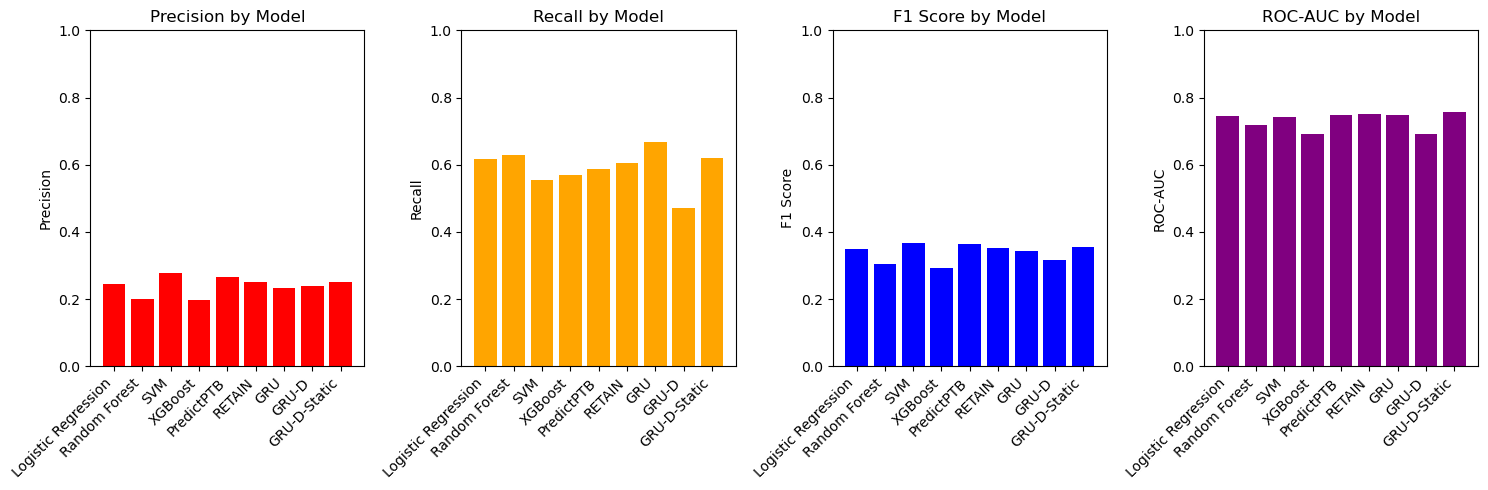

                 Model  Precision  Recall  F1 Score  ROC-AUC
0  Logistic Regression      0.244   0.617     0.349    0.745
1        Random Forest      0.202   0.629     0.304    0.718
2                  SVM      0.276   0.555     0.368    0.741
3              XGBoost      0.198   0.568     0.292    0.691
4           PredictPTB      0.267   0.587     0.363    0.749
5               RETAIN      0.250   0.605     0.352    0.750
6                  GRU      0.234   0.669     0.343    0.748
7                GRU-D      0.239   0.470     0.315    0.691
8         GRU-D-Static      0.251   0.620     0.356    0.755
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 

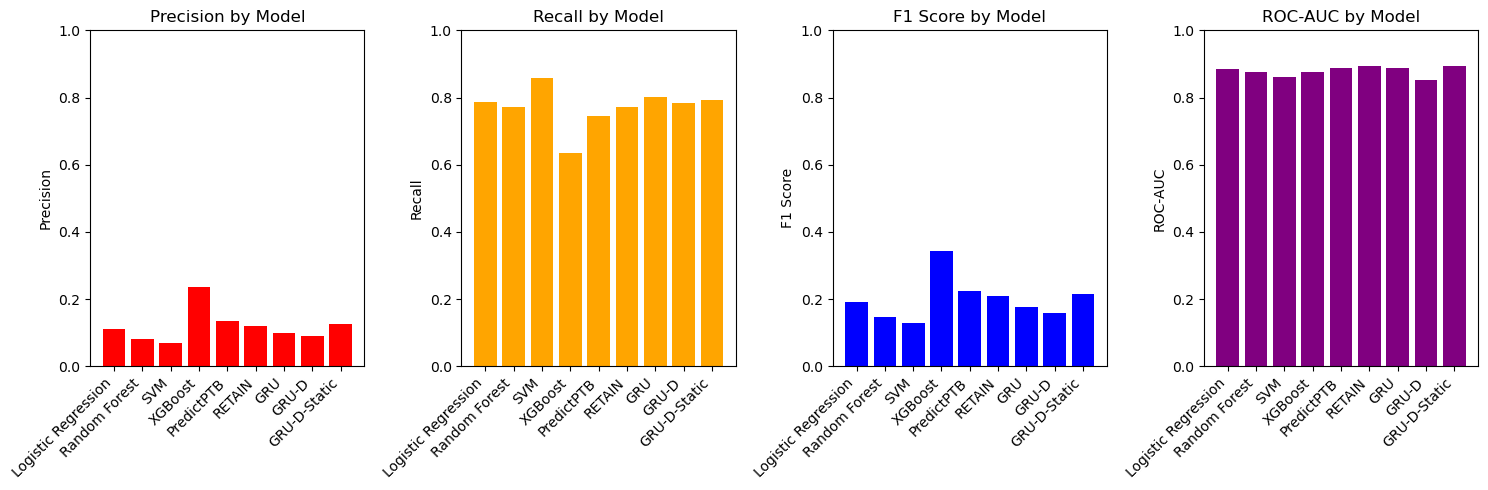

                 Model  Precision  Recall  F1 Score  ROC-AUC
0  Logistic Regression      0.110   0.787     0.192    0.885
1        Random Forest      0.082   0.771     0.147    0.876
2                  SVM      0.070   0.857     0.128    0.862
3              XGBoost      0.235   0.635     0.342    0.876
4           PredictPTB      0.134   0.745     0.224    0.889
5               RETAIN      0.121   0.772     0.208    0.894
6                  GRU      0.099   0.803     0.175    0.889
7                GRU-D      0.089   0.783     0.158    0.852
8         GRU-D-Static      0.126   0.794     0.216    0.894
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 

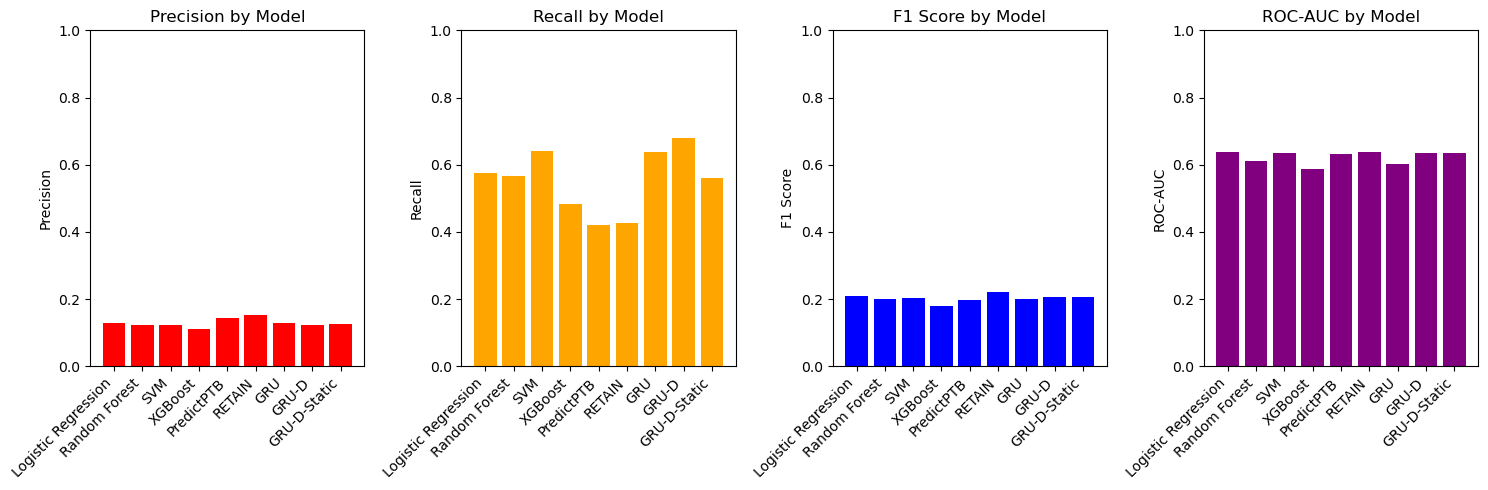

                 Model  Precision  Recall  F1 Score  ROC-AUC
0  Logistic Regression      0.128   0.577     0.209    0.638
1        Random Forest      0.122   0.565     0.200    0.610
2                  SVM      0.121   0.641     0.204    0.634
3              XGBoost      0.111   0.484     0.180    0.587
4           PredictPTB      0.144   0.421     0.198    0.632
5               RETAIN      0.153   0.427     0.221    0.637
6                  GRU      0.128   0.639     0.201    0.602
7                GRU-D      0.122   0.680     0.206    0.634
8         GRU-D-Static      0.127   0.560     0.206    0.635
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 

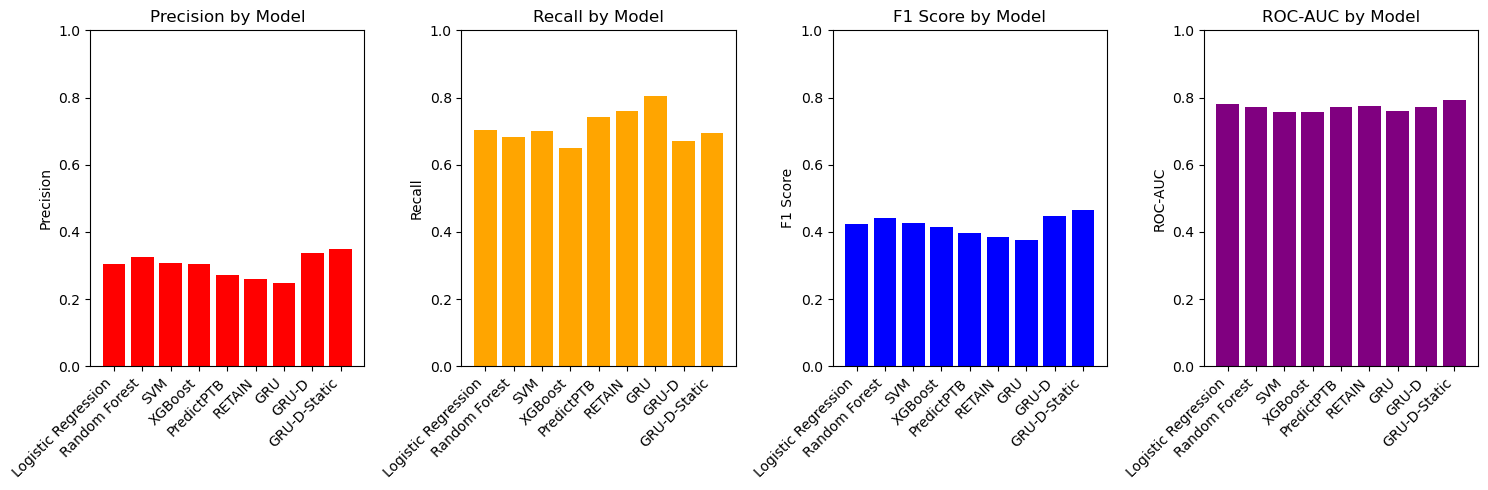

                 Model  Precision  Recall  F1 Score  ROC-AUC
0  Logistic Regression      0.305   0.705     0.424    0.781
1        Random Forest      0.326   0.683     0.440    0.773
2                  SVM      0.308   0.699     0.426    0.758
3              XGBoost      0.306   0.650     0.415    0.757
4           PredictPTB      0.271   0.741     0.396    0.773
5               RETAIN      0.259   0.760     0.385    0.775
6                  GRU      0.248   0.805     0.375    0.760
7                GRU-D      0.338   0.670     0.448    0.771
8         GRU-D-Static      0.349   0.694     0.464    0.792


In [2]:
# Initialize an empty list to store results
results_best = []

# Function to process results for an outcome
def process_results(outcome):
    # Run the function and capture the returned values
    results_summary, threshold = print_results(outcome)

    print(results_summary)
    
    # Extract best-performing models for each metric
    best_precision = results_summary.loc[results_summary["Precision"].idxmax(), ["Model", "Precision"]]
    best_recall = results_summary.loc[results_summary["Recall"].idxmax(), ["Model", "Recall"]]
    best_f1 = results_summary.loc[results_summary["F1 Score"].idxmax(), ["Model", "F1 Score"]]
    best_roc_auc = results_summary.loc[results_summary["ROC-AUC"].idxmax(), ["Model", "ROC-AUC"]]

    # Append results to the list
    results_best.append({
        "Outcome": outcome,
        "Prevalence (%)": f"{threshold * 100:.2f}",
        "Best Precision Model": best_precision["Model"],
        "Best Precision Score": f"{best_precision['Precision']:.3f}",
        "Best Recall Model": best_recall["Model"],
        "Best Recall Score": f"{best_recall['Recall']:.3f}",
        "Best F1 Score Model": best_f1["Model"],
        "Best F1 Score": f"{best_f1['F1 Score']:.3f}",
        "Best ROC-AUC Model": best_roc_auc["Model"],
        "Best ROC-AUC Score": f"{best_roc_auc['ROC-AUC']:.3f}"
    })

# List of outcomes to process
outcomes = ['INF_ASPH', 'STILLBIRTH_SIGNS_LIFE','INF_PSBI_IPC','INF_JAUN_NON_SEV_ANY']

# Run the function for each outcome
for outcome in outcomes:
    process_results(outcome)

# Convert the list to a DataFrame
summary_df = pd.DataFrame(results_best)

In [3]:
summary_df

summary_df.to_excel("D:/Users/yipeng_wei/Documents/dl data/2025-01-10/ultrasound & biomarkers & basic.xlsx", index=False)